# Compute Segmentations on PathFinder-SEGMENTATION Dataset
This notebook is for inspecting the PathFinder-SEGMENTATION dataset and formatting it into a Meerkat dataset.

> **Simplifying and Understanding State Space Models with Diagonal Linear RNNs**\
> Ankit Gupta, Harsh Mehta, Jonathan Berant\
> Paper: https://arxiv.org/abs/2212.00768


In [40]:
import pickle as pik
import numpy as np
import torch
import matplotlib.pyplot as plt
import PIL
import pickle as pik

import os
import pandas as pd

import meerkat as mk
from meerkat.interactive.formatter.image import ImageFormatterGroup

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
# The path to the pathfinder-segmentation dataset.
pathfinder_path = "/Users/arjundd/code/dlr/src/dataloaders/prepare/pathfinder/data/pathfinder256_segmentation"

In [42]:
def extract_metadata(dirpath, base_path: str):
    """Extract the filepath and label from the metadata file.

    Example metadata:
        ['imgs/43', 'sample_0.png', '0', '0', '1.8', '6', '2.0', '5', '1.5', '2', '1']
    
    Args:
        file_path: Path to the metadata file.
    """
    metadata_dir = os.path.join(dirpath, "metadata")
    image_paths = []
    labels = []
    for metadata_file in os.listdir(metadata_dir):
        file_path = os.path.join(metadata_dir, metadata_file)
        meta_examples = np.load(file_path)
        for m_example in meta_examples:
            image_paths.append(os.path.join(base_path, m_example[0], m_example[1]))
            labels.append(int(m_example[3]))
    return {"path": image_paths, "label": labels}


def get_segmentation_path(image_path):
    """Get the segmentation path from the image path."""
    return image_path.replace("imgs", "paths").replace(".png", ".pkl")


def load_segmentation(seg_path):
    """Load the segmentation from a file."""
    with open(seg_path, "rb") as f:
        data = pik.load(f)
    d = data
    [origin_mark_idx, terminal_mark_idx] = d['marker_indices']

    paths = []
    for i, path_inds in enumerate(d['segs']):
        path = np.zeros(d['image_size'], dtype=np.int16)
        path[path_inds] = 1 + (origin_mark_idx == terminal_mark_idx == i)
        paths.append(path)
    return torch.LongTensor(np.maximum(*paths))

_COLORS = [
    (0, 0, 0),
    (255, 0, 0),
    (0, 0, 255),
]
_COLORS = [np.asarray(c) for c in _COLORS]


def colorize(x: torch.Tensor) -> PIL.Image:
    """Colorize the segmentation array.

    Args:
        x: An array representing the segmentation (..., num_classes)

    Returns:
        An array of shape (..., 4) where the last dimension is RGBA.
    """
    arr = x.numpy()
    arr = np.zeros(x.shape + (3,), dtype=np.uint8)
    num_classes = 3
    for k in range(num_classes):
        arr[x == k] = _COLORS[k]
    return PIL.Image.fromarray(arr, "RGB")


In [45]:
# Format the metadata for each subfolder.
df = pd.DataFrame(extract_metadata(pathfinder_path, base_path=os.path.join(pathfinder_path, "")))
df["seg_path"] = df["path"].apply(get_segmentation_path)

df_pd = df.reset_index(drop=True)

df = mk.DataFrame.from_pandas(df_pd)
df["image"] = mk.files(df["path"], type="image")
df["seg"] = mk.files(df["seg_path"], loader=load_segmentation)
df["seg_colorized"] = df["seg"].defer(colorize)
df["seg_colorized"].formatters = ImageFormatterGroup().defer()

df = df.drop(columns="index")

,path,label,seg_path,image,seg,seg_colorized
0,...,0,...,,"tensor([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0,...",
1,...,0,...,,"tensor([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0,...",
2,...,1,...,,"tensor([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0,...",
3,...,1,...,,"tensor([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0,...",
4,...,0,...,,"tensor([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0,...",

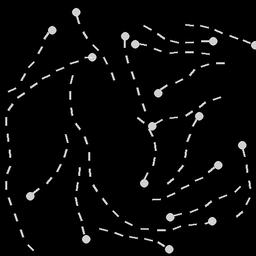
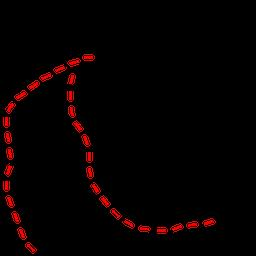
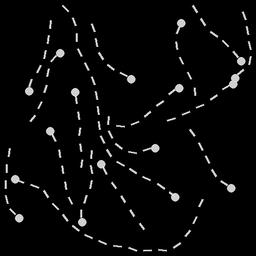
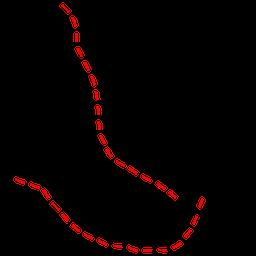
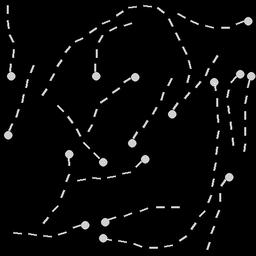
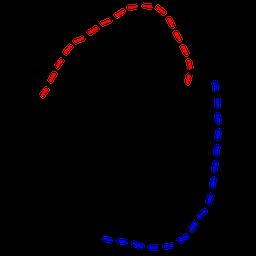
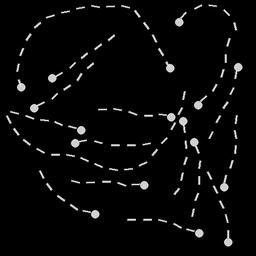
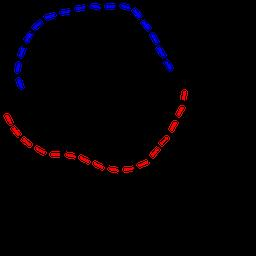
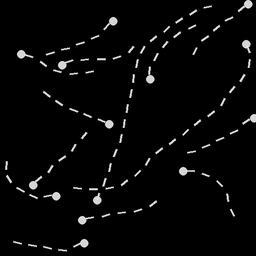
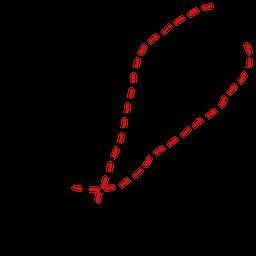

In [46]:
df.head()

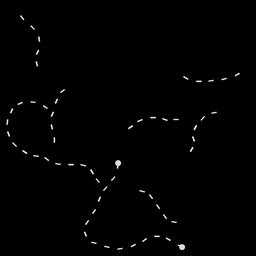

In [33]:
img = PIL.Image.open("/Users/arjundd/code/dlr/src/dataloaders/prepare/pathfinder/data/imgs/0/sample_2.png")
img

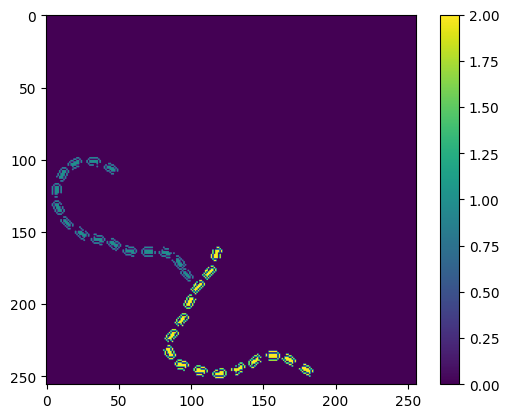

In [35]:
with open("/Users/arjundd/code/dlr/src/dataloaders/prepare/pathfinder/data/paths/0/sample_2.pkl", "rb") as f:
    data = pik.load(f)

d = data
[origin_mark_idx, terminal_mark_idx] = d['marker_indices']

paths = []
for i, path_inds in enumerate(d['segs']):
    path = np.zeros(d['image_size'], dtype=np.int16)
    path[path_inds] = 1 + (origin_mark_idx == terminal_mark_idx == i)
    paths.append(path)
label_mask = torch.LongTensor(np.maximum(*paths))        

plt.imshow(label_mask)
plt.colorbar()

In [31]:
import numpy as np
data = np.load("/Users/arjundd/code/dlr/src/dataloaders/prepare/pathfinder/data/metadata/0.npy")
data[2]

array(['imgs/0', 'sample_2.png', '2', '1', '1.4', '15', '5', '5', '1.5',
       '4', '1'], dtype='<U32')